# Visual Network Analysis
Sources:
- https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259
- https://stackoverflow.com/questions/72640093/how-to-query-twitter-api-public-metrics-for-multiple-tweet-ids-using-tweepy

## 1. Importing Libraries and Data

### 1.1 Importing libraries

In [ ]:
# editing data
import pandas as pd
import re

# where are these used?
import numpy as np
import tweepy
from collections import defaultdict
import time # Needed for some API v2 (Client interface) methods to avoid rate limiting
import ast # String representation of dictionary to dictionary (tweet_entities); used to extract hashtags from Tweets
from ast import literal_eval
import datetime as dt

# plotting
import networkx as nx
import matplotlib.pyplot as plt

### 1.2 Setting up authentication for using Twitter API:

In [ ]:
# does this need to be used if we have the user data?
from AppCred import BEARER_TOKEN
from AppCred import CONSUMER_KEY, CONSUMER_SECRET
from AppCred import ACCESS_TOKEN, ACCESS_TOKEN_SECRET

client = tweepy.Client(bearer_token = BEARER_TOKEN,
                       consumer_key = CONSUMER_KEY,
                       consumer_secret = CONSUMER_SECRET,
                       access_token = ACCESS_TOKEN,
                       access_token_secret = ACCESS_TOKEN_SECRET,
                       return_type = dict,         # return the response as a Python dictionary
                       wait_on_rate_limit = True)  # wait once the rate limit is reached

### 1.3 Reading in the Data

In [ ]:
#df = pd.read_csv('preprocessed_all_user_tweets.csv', converters={'tweet_id': lambda x: str(x), 'original_tweet_id': lambda x: str(x)})

In [ ]:
df = pd.read_csv('20230526_tweets_inflation.csv')
len(df)

16595

In [ ]:
df.head()

,id,username,text,tweet_id,created_at,retweeted,original_tweet_id,retweets,replies,likes,impression,tokens_no_stopwords,tokens,text_stemmed,text_lemmatized,mention,expenses_dict,tokens_str,tokens_no_stopwords_str,inflation
0,350223904,abenaopp,RT @RachelReevesMP: The reality of today’s inf...,1661276959718899713,2023-05-24T07:44:26.000Z,1.0,1661252858665406465,222.0,0.0,0.0,0.0,"['reality', 'todays', 'inflation', 'figures', ...","['the', 'reality', 'of', 'todays', 'inflation'...",realiti today inflat figur soar food price sta...,reality today inflation figure soar food price...,['RachelReevesMP'],1.0,the reality of todays inflation figures are so...,reality todays inflation figures soaring food ...,True
1,350223904,abenaopp,RT @patmcfaddenmp: Interest rates rising. UK i...,1656939809678434305,2023-05-12T08:30:09.000Z,1.0,1656938533989261312,116.0,0.0,0.0,0.0,"['interest', 'rates', 'rising', 'uk', 'inflati...","['interest', 'rates', 'rising', 'uk', 'inflati...",interest rate rise uk inflat higher longer dec...,interest rate rise uk inflation high long decl...,['patmcfaddenmp'],0.0,interest rates rising uk inflation higher for ...,interest rates rising uk inflation higher long...,True
2,350223904,abenaopp,RT @ShabanaMahmood: Labour spent the whole loc...,1654396149682393089,2023-05-05T08:02:33.000Z,1.0,1654390340562853889,62.0,0.0,0.0,0.0,"['labour', 'spent', 'whole', 'local', 'electio...","['labour', 'spent', 'the', 'whole', 'local', '...",labour spent whole local elect campaign talk p...,labour spend whole local election campaign tal...,['ShabanaMahmood'],0.0,labour spent the whole local election campaign...,labour spent whole local election campaign tal...,True
3,350223904,abenaopp,RT @UKLabour: We are on course for a majority ...,1654395774006951936,2023-05-05T08:01:04.000Z,1.0,1654394089112993792,362.0,0.0,0.0,0.0,"['course', 'majority', 'labour', 'government',...","['we', 'are', 'on', 'course', 'for', 'a', 'maj...",cours major labour govern one cut cost live cu...,course majority labour government one cut cost...,['UKLabour'],0.0,we are on course for a majority labour governm...,course majority labour government one cuts cos...,True
4,350223904,abenaopp,RT @patmcfaddenmp: BoE Governor clear on ⁦@BBC...,1639224454080282624,2023-03-24T11:15:39.000Z,1.0,1639201557836345345,17.0,0.0,0.0,0.0,"['boe', 'governor', 'clear', 'bbcrtoday', 'exp...","['boe', 'governor', 'clear', 'on', 'bbcrtoday'...",boe governor clear bbcrtoday expect inflat fal...,boe governor clear bbcrtoday expect inflation ...,"['patmcfaddenmp', 'BBCr4today']",0.0,boe governor clear on bbcrtoday he expects inf...,boe governor clear bbcrtoday expects inflation...,True


# 2. Reducing Dataset to Identify Networks

### 2.1 Identifying Retweeted Users (Csilla)

In [ ]:
retweets_users = []

pattern = r'^RT @(\w+)'
for tweet in list(df.text):
    match = re.search(pattern, tweet)
    if match:
        retweets_users.append(match.group(1))
    else:
        retweets_users.append(None)

df['retweeted_username'] = retweets_users

### 2.2 Reducing Dataframe to Retweeted Tweets and Their Retweets (Csilla)

In [ ]:
actors = set(df.username)
retweets_df = df[df.retweeted_username.isin(actors)]
len(retweets_df)

3593

In [ ]:
retweets_df.head()

,id,username,text,tweet_id,created_at,retweeted,original_tweet_id,retweets,replies,likes,...,tokens_no_stopwords,tokens,text_stemmed,text_lemmatized,mention,expenses_dict,tokens_str,tokens_no_stopwords_str,inflation,retweeted_username
0,350223904,abenaopp,RT @RachelReevesMP: The reality of today’s inf...,1661276959718899713,2023-05-24T07:44:26.000Z,1.0,1661252858665406465,222.0,0.0,0.0,...,"['reality', 'todays', 'inflation', 'figures', ...","['the', 'reality', 'of', 'todays', 'inflation'...",realiti today inflat figur soar food price sta...,reality today inflation figure soar food price...,['RachelReevesMP'],1.0,the reality of todays inflation figures are so...,reality todays inflation figures soaring food ...,True,RachelReevesMP
1,350223904,abenaopp,RT @patmcfaddenmp: Interest rates rising. UK i...,1656939809678434305,2023-05-12T08:30:09.000Z,1.0,1656938533989261312,116.0,0.0,0.0,...,"['interest', 'rates', 'rising', 'uk', 'inflati...","['interest', 'rates', 'rising', 'uk', 'inflati...",interest rate rise uk inflat higher longer dec...,interest rate rise uk inflation high long decl...,['patmcfaddenmp'],0.0,interest rates rising uk inflation higher for ...,interest rates rising uk inflation higher long...,True,patmcfaddenmp
3,350223904,abenaopp,RT @UKLabour: We are on course for a majority ...,1654395774006951936,2023-05-05T08:01:04.000Z,1.0,1654394089112993792,362.0,0.0,0.0,...,"['course', 'majority', 'labour', 'government',...","['we', 'are', 'on', 'course', 'for', 'a', 'maj...",cours major labour govern one cut cost live cu...,course majority labour government one cut cost...,['UKLabour'],0.0,we are on course for a majority labour governm...,course majority labour government one cuts cos...,True,UKLabour
4,350223904,abenaopp,RT @patmcfaddenmp: BoE Governor clear on ⁦@BBC...,1639224454080282624,2023-03-24T11:15:39.000Z,1.0,1639201557836345345,17.0,0.0,0.0,...,"['boe', 'governor', 'clear', 'bbcrtoday', 'exp...","['boe', 'governor', 'clear', 'on', 'bbcrtoday'...",boe governor clear bbcrtoday expect inflat fal...,boe governor clear bbcrtoday expect inflation ...,"['patmcfaddenmp', 'BBCr4today']",0.0,boe governor clear on bbcrtoday he expects inf...,boe governor clear bbcrtoday expects inflation...,True,patmcfaddenmp
5,350223904,abenaopp,RT @patmcfaddenmp: Energy bills are scheduled ...,1631203539308380160,2023-03-02T08:03:24.000Z,1.0,1630979791963684866,70.0,0.0,0.0,...,"['energy', 'bills', 'scheduled', 'go', '£', 'y...","['energy', 'bills', 'are', 'scheduled', 'to', ...",energi bill schedul go £ year next month gover...,energy bill schedule go £ year next month gove...,['patmcfaddenmp'],1.0,energy bills are scheduled to go up by £ a yea...,energy bills scheduled go £ year next month go...,True,patmcfaddenmp


### 2.3 Identifying Mentions (Carolina)

In [ ]:
# retrieving mentions and RTs
# aren't we repeating sth here?
retweets_df['mention'] =  retweets_df['text'].apply(lambda x: re.findall(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9_]+)', str(x)))

C:\Users\Csilla\AppData\Local\Temp\ipykernel_30080\2877327395.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retweets_df['mention'] =  retweets_df['text'].apply(lambda x: re.findall(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9_]+)', str(x)))


In [ ]:
# removing RT's from the mentions column and keeping only the mentions
for index, row in retweets_df.iterrows():
    if row['retweeted'] == 1:
        mentions_list = row['mention']
        if len(mentions_list) > 0:
            mentions_list.pop(0)
            retweets_df.at[index, 'mention'] = mentions_list

### 2.4 Reducing Dataframe to Tweets That Contain Mentions (Carolina)

In [ ]:
mentions_df = retweets_df.copy()
mentions_df['mention'] = mentions_df['mention'].apply(lambda x: np.nan if x == '[]' else x)

# Disaggregate names within lists for posterior visualization
mentions_df['mention'] = mentions_df['mention'].apply(lambda x: x.strip('[]').split(', ') if isinstance(x, str) else x)
mentions_df = mentions_df.explode('mention')
mentions_df = mentions_df.dropna(subset = ['mention'])

# Reset index
mentions_df = mentions_df.reset_index(drop = True)

In [ ]:
len(mentions_df)

295

# 3. Creating Networks

### 3.1 Graph containing only retweet interactions (G)

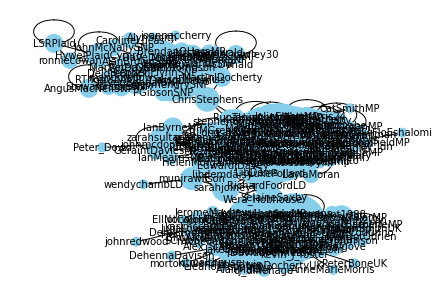

In [ ]:
G = nx.from_pandas_edgelist(retweets_df,
                            source = 'username' ,
                            target = 'retweeted_username')
G = nx.Graph(G)
degrees = nx.degree(G)
degree_values = [v for k, v in degrees]

nx.draw(G,
        node_size = [v * 80 for v in degree_values],
        with_labels = True,
        node_color = 'skyblue',
        pos = nx.kamada_kawai_layout(G),
        font_size = 10)

nx.write_gexf(G, "graph_networkx_only_retweets.gexf")

### 3.2 Graph containing only mentions from users (H)

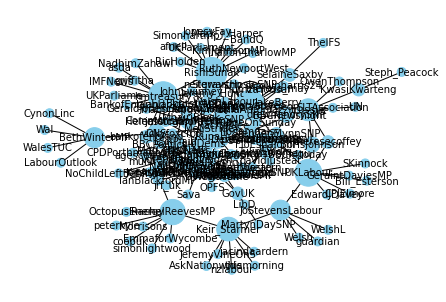

In [ ]:
H = nx.from_pandas_edgelist(mentions_df,
                            source = 'retweeted_username',
                            target = 'mention')

H = nx.Graph(H)
degrees = nx.degree(H)
degree_values = [v for k, v in degrees]

nx.draw(H,
        node_size = [v * 80 for v in degree_values],
        with_labels = True,
        node_color = 'skyblue',
        pos = nx.kamada_kawai_layout(H),
        font_size = 10)

nx.write_gexf(H, "graph_networkx_only_mentions.gexf")

### 3.3 Calculating network metrics (cc, degree)

In [ ]:
#cc = nx.closeness_centrality(G)
#sorted(cc, key=lambda x: x[1], reverse=True)

In [ ]:
#cc_H = nx.closeness_centrality(H)
#sorted(cc_H, key=lambda x: x[1], reverse=True)

In [ ]:
#sorted(G.degree, key=lambda x: x[1], reverse=True)

In [ ]:
#sorted(H.degree, key=lambda x: x[1], reverse=True)

# 4. Plotting networks with pyvis

### 4.1 Only retweets network:

In [ ]:
from pyvis.network import Network

net = Network(notebook=True)
net.from_nx(G) # getting data from networkx
net.show('graph_retweets.html')
net.save_graph('graph_retweets.html')

graph_retweets.html


### 4.2 Only mentions network:

In [ ]:
# mentions network (note: only mentions, not retweets)
net = Network(notebook=True)
net.from_nx(H) # getting data from networkx
net.show('graph_mentions.html')
net.save_graph('graph_mentions.html')

graph_mentions.html


### 4.3 Color-coded network (will be useful in the future):

In [ ]:
net = Network(notebook=True)
# create graph using pviz network
sources = retweets_df['username']
targets = retweets_df['retweeted_username']
condition = retweets_df['Inflation mention']

edge_data = zip(sources, targets, condition)

for src, dst, condition in edge_data:
    #add nodes and edges to the graph
    if condition == False:
        net.add_node(src, src, title=src, color='red')
    if condition == True:
        net.add_node(dst, dst, title=dst, color='blue')

    #net.add_edge(src, dst)

net.show('graph_2.html')

KeyError: 'Inflation mention'

# 5. Combining retweets and mentions graphs (F)

### 5.1

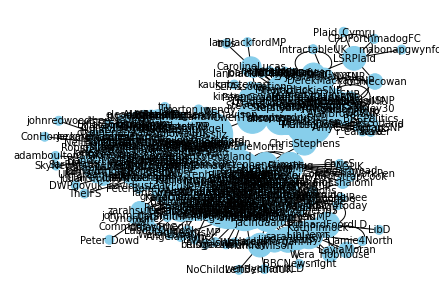

In [ ]:
F = nx.compose(G, H)

degrees = nx.degree(F)
degree_values = [v for k, v in degrees]

nx.draw(F,
        node_size = [v * 80 for v in degree_values],
        with_labels = True,
        node_color = 'skyblue',
        pos = nx.kamada_kawai_layout(F),
        font_size = 10)

nx.write_gexf(F, "networkx_metions_and_rts.gexf")

### 5.2 Using pyvis

In [ ]:
net = Network(notebook = True)
net.from_nx(F) # getting data from networkx
net.save_graph('graph_retweets_and_mentions.html')
net.show('graph_retweets_and_mentions.html')

graph_retweets_and_mentions.html


### 5.3 Creating user dataset from response object (Carolina: working on it rn)

In [ ]:
# Initialize empty lists to store Twitter information
user_id = []
username = []
created_at = []
verified_status = []
following = []
followers = []

# Iterate through each row in the dataframe
for user__id in set(reduced_df.id):
    # Retrieve user information using Tweepy
    user = client.get_user(id = user__id)['data']['id'] # retrieving user object from user id
    metrics = client.get_user(id = user, user_fields = ['verified','created_at','public_metrics']) #retrieving metrics

    user_id.append(user__id)
    username.append(metrics['data']['username'])
    created_at.append(metrics['data']['created_at'])
    verified_status.append(metrics['data']['verified']) # appending verified status
    following.append(metrics['data']['public_metrics']['following_count'])
    followers.append(metrics['data']['public_metrics']['followers_count'])

user_df = pd.DataFrame({"user_id":user_id,
                        "username":username,
                        "created_at":created_at,"verified_status": verified_status,
                       'following':following,
                       'followers':followers})

# Save the new dataframe to a CSV file
#twitter_info_df.to_csv("twitter_info_dataframe.csv", index=False)

In [ ]:
user_df

,user_id,username,created_at,verified_status,following,followers
0,1168968080690749441,RishiSunak,2019-09-03T19:25:03.000Z,True,268,2007610
1,707967655031005186,KwasiKwarteng,2016-03-10T16:33:37.000Z,False,672,93619
2,77821953,theSNP,2009-09-27T20:19:48.000Z,False,1341,340321
3,1526871150965440513,RichardFoordLD,2022-05-18T10:23:55.000Z,False,377,12255
4,112398730,Jeremy_Hunt,2010-02-08T10:38:50.000Z,False,1268,259217
5,116459535,alisonthewliss,2010-02-22T14:41:54.000Z,False,9213,33765
6,23056912,AlynSmith,2009-03-06T12:16:16.000Z,False,5550,46249
7,219298196,StewartHosieSNP,2010-11-24T13:38:41.000Z,False,1195,29144
8,23424533,LaylaMoran,2009-03-09T11:24:04.000Z,False,5001,82933
9,3131144855,BorisJohnson,2015-04-01T20:15:49.000Z,True,465,4754159


In [ ]:
actors_info = pd.read_csv('20230520_description_actors.xlsx - Sheet1.csv')

In [ ]:
# Extract the common usernames
common_usernames = set(user_df['username']).intersection(set(actors_info['username']))

# Filter the rows in df2 based on the common usernames
filtered_df2 = actors_info[actors_info['username'].isin(common_usernames)]

# Merge the dataframes on the 'username' column
merged_df = user_df.merge(filtered_df2[['username', 'Political affiliation', 'department']], on='username', how='left')

# Print the merged dataframe
merged_df

,user_id,username,created_at,verified_status,following,followers,Political affiliation,department
0,1168968080690749441,RishiSunak,2019-09-03T19:25:03.000Z,True,268,2007610,Conservative,hm_treasury_government
1,707967655031005186,KwasiKwarteng,2016-03-10T16:33:37.000Z,False,672,93619,Conservative,mp_other
2,77821953,theSNP,2009-09-27T20:19:48.000Z,False,1341,340321,Scottish National Party,political_party
3,1526871150965440513,RichardFoordLD,2022-05-18T10:23:55.000Z,False,377,12255,Liberal Democrats,spokesperson
4,112398730,Jeremy_Hunt,2010-02-08T10:38:50.000Z,False,1268,259217,Conservative,hm_treasury_government
5,116459535,alisonthewliss,2010-02-22T14:41:54.000Z,False,9213,33765,Scottish National Party,spokesperson
6,23056912,AlynSmith,2009-03-06T12:16:16.000Z,False,5550,46249,Scottish National Party,spokesperson
7,219298196,StewartHosieSNP,2010-11-24T13:38:41.000Z,False,1195,29144,Scottish National Party,spokesperson
8,23424533,LaylaMoran,2009-03-09T11:24:04.000Z,False,5001,82933,Liberal Democrats,spokesperson
9,3131144855,BorisJohnson,2015-04-01T20:15:49.000Z,True,465,4754159,Conservative,mp_before


In [ ]:
color_map = {'Conservative': 'blue',
               'Labour party': 'red',
               'Scottish National Party': 'green',
               'Liberal Democrats': 'purple'}
merged_df['node_color'] = merged_df['Political affiliation'].map(node_colors)

node_colors = [color_map.get(affiliation, 'white') for affiliation in merged_df['Political affiliation']]


TypeError: 'list' object is not callable

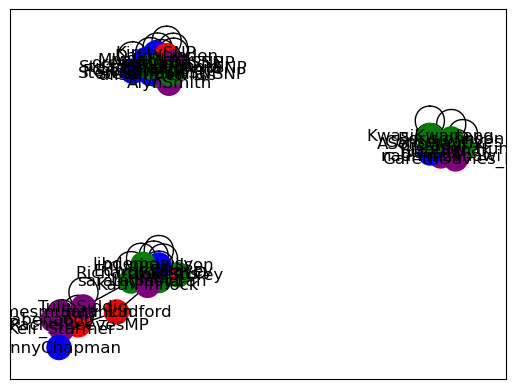

In [ ]:
nx.draw_networkx(G, pos=nx.spring_layout(G), node_color=node_colors, with_labels=True)

# Csillas addition: Graph visualisation

In [ ]:
# creating graph
len(set(retweets_df.username))

209

In [ ]:
retweets_df.columns

Index(['id', 'username', 'text', 'tweet_id', 'created_at', 'retweeted',
       'original_tweet_id', 'retweets', 'replies', 'likes', 'impression',
       'tokens_no_stopwords', 'tokens', 'text_stemmed', 'text_lemmatized',
       'mention', 'expenses_dict', 'tokens_str', 'tokens_no_stopwords_str',
       'inflation', 'retweeted_username'],
      dtype='object')

In [ ]:
retweets_df = retweets_df[retweets_df.username != retweets_df.retweeted_username]
len(retweets_df)

3470

In [ ]:
G = nx.from_pandas_edgelist(retweets_df,
                            source = 'username' ,
                            target = 'retweeted_username')
G = nx.Graph(G)

In [ ]:
user_data_df.head()

,data,id,name,username,created_at,description,followers_count,following_count,tweet_count,listed_count,username_key,real_name,Party,Position,Elected_since,Parliament_page,appgs,committees
0,"{'username': 'abenaopp', 'description': 'Lab M...",350223904,Abena Oppong-Asare MP,abenaopp,2011-08-07T12:12:07.000Z,Lab MP for Erith & Thamesmead | Shadow Exchequ...,19748,3627,17038,263,abenaopp,Abena Oppong-Asare,Labour,Shadow Exchequer Secretary (Treasury),2019-12-12,https://members.parliament.uk/member/4820/contact,Equipment for Disabled Children| Ethnic Minori...,UK Infrastructure Bank Bill [Lords]| Finance (...
1,"{'public_metrics': {'followers_count': 25148, ...",143739561,Alex Cunningham MP,ACunninghamMP,2010-05-14T08:07:21.000Z,Labour MP for Stockton North | Shadow Justice ...,25148,1375,34558,574,acunninghammp,Alex Cunningham,Labour,Shadow Minister (Justice),2010-05-06,https://members.parliament.uk/member/4122/contact,"Carbon Capture, Utilisation and Storage| Carbo...",Judicial Review and Courts Bill| Public Order ...
2,"{'created_at': '2015-02-01T22:04:33.000Z', 'id...",3011043981,Alan Brown MP,AlanBrownSNP,2015-02-01T22:04:33.000Z,MP for Kilmarnock & Loudoun. Long-suffering Ki...,13224,900,6188,373,alanbrownsnp,Alan Brown,Scottish National Party,Shadow SNP Spokesperson (Energy Security and N...,2015-05-07,https://members.parliament.uk/member/4470/contact,Chagos (British Indian Ocean Territory)| Croat...,Business and Trade Committee| Education (Caree...
3,"{'created_at': '2014-06-11T15:17:47.000Z', 'id...",2601366250,Alan Campbell MP,alancampbellmp,2014-06-11T15:17:47.000Z,Member of Parliament for Tynemouth and Opposit...,7853,328,2280,367,alancampbellmp,Alan Campbell,Labour,Shadow Chief Whip (Commons),1997-05-01,https://members.parliament.uk/member/529/contact,NaN,NaN
4,"{'username': 'AlanMakMP', 'created_at': '2013-...",2157036506,Alan Mak MP 🇬🇧 🏴󠁧󠁢󠁥󠁮󠁧󠁿,AlanMakMP,2013-10-26T15:14:38.000Z,Member of Parliament for the Havant Constituen...,11447,2974,5544,404,alanmakmp,Alan Mak,Conservative,NaN,2015-05-07,https://members.parliament.uk/member/4484/contact,South Western Railway,Joint Committee on the Fixed-Term Parliaments ...


In [ ]:
# importing user data for colour-coding
user_data_df = pd.read_excel('20230526_description_actors.xlsx')
user_data_df.username

0            abenaopp
1       ACunninghamMP
2        AlanBrownSNP
3      alancampbellmp
4           AlanMakMP
            ...      
219    theodoraclarke
220            theSNP
221       tomhunt1988
222     tony4rochdale
223          UKLabour
Name: username, Length: 224, dtype: object

In [ ]:
actors_graph_G = set(G.nodes)
user_data_df = user_data_df[user_data_df.username.isin(actors_graph_G)]
len(user_data_df)

212

In [ ]:
# colour-coding based on parties
color_map = {'Conservative': '#0087DC',
             'Democratic Unionist Party': '#D46A4C',
             'Green Party': '#528D6B',
             'Independent': '#DCDCDC',
             'Labour': '#E4003B',
             'Labour (Co-op)': '#E4003B',
             'Liberal Democrat': '#FAA61A',
             'Plaid Cymru': '#005B54',
             'Scottish National Party': '#FDF38E'
             }

node_colors = [color_map.get(affiliation, '#DCDCDC') for affiliation in user_data_df['Party']]


In [ ]:
# create a dictionary for the degrees for node size
d = dict(G.degree)

In [ ]:
retweets_df.sort_values('created_at').reset_index(drop = True).index

RangeIndex(start=0, stop=3593, step=1)

In [ ]:
# adjust hue based on posted date
max_value = retweets_df.sort_values('created_at').reset_index(drop = True).index.max()
alpha = [i / max_value / 2 + 0.5 for i in retweets_df.sort_values('created_at').reset_index(drop = True).index]

1.0

In [ ]:
# adjust node_size
node_size = [v * 50 for v in d.values()]

In [ ]:
# for double-checking it works:
# user_data_df['node_color'] = user_data_df['Party'].map(lambda affiliation: color_map.get(affiliation, '#DCDCDC'))
# user_data_df[user_data_df.Party.isnull()]

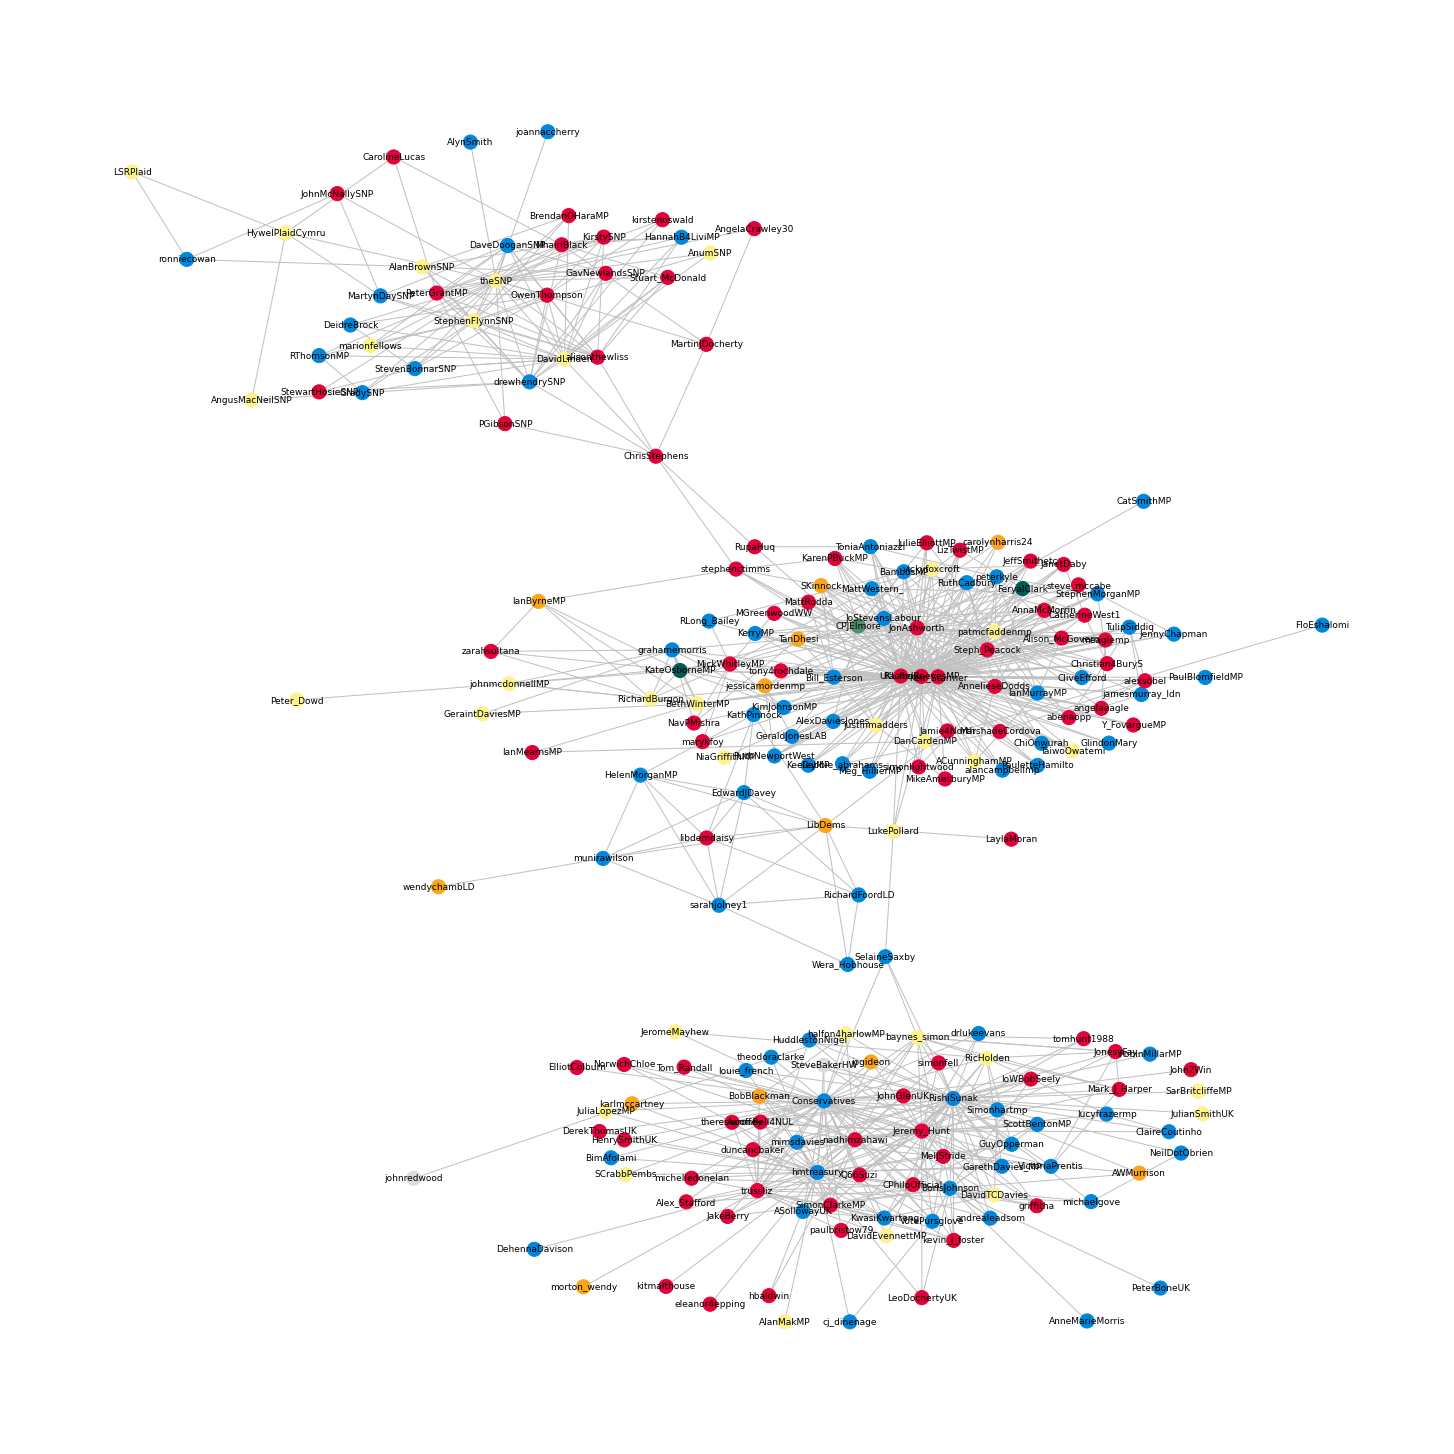

In [ ]:
# set up params for layout
params1 = {'font_size': 9, 'with_labels': True, 'node_size': 200, 'node_color': node_colors, 'font_color': 'black', 'alpha': 1, 'edge_color': 'silver', 'width': 1}

plt.figure(figsize = (20, 20))
nx.draw(G, pos = nx.kamada_kawai_layout(G), **params1)
plt.show()

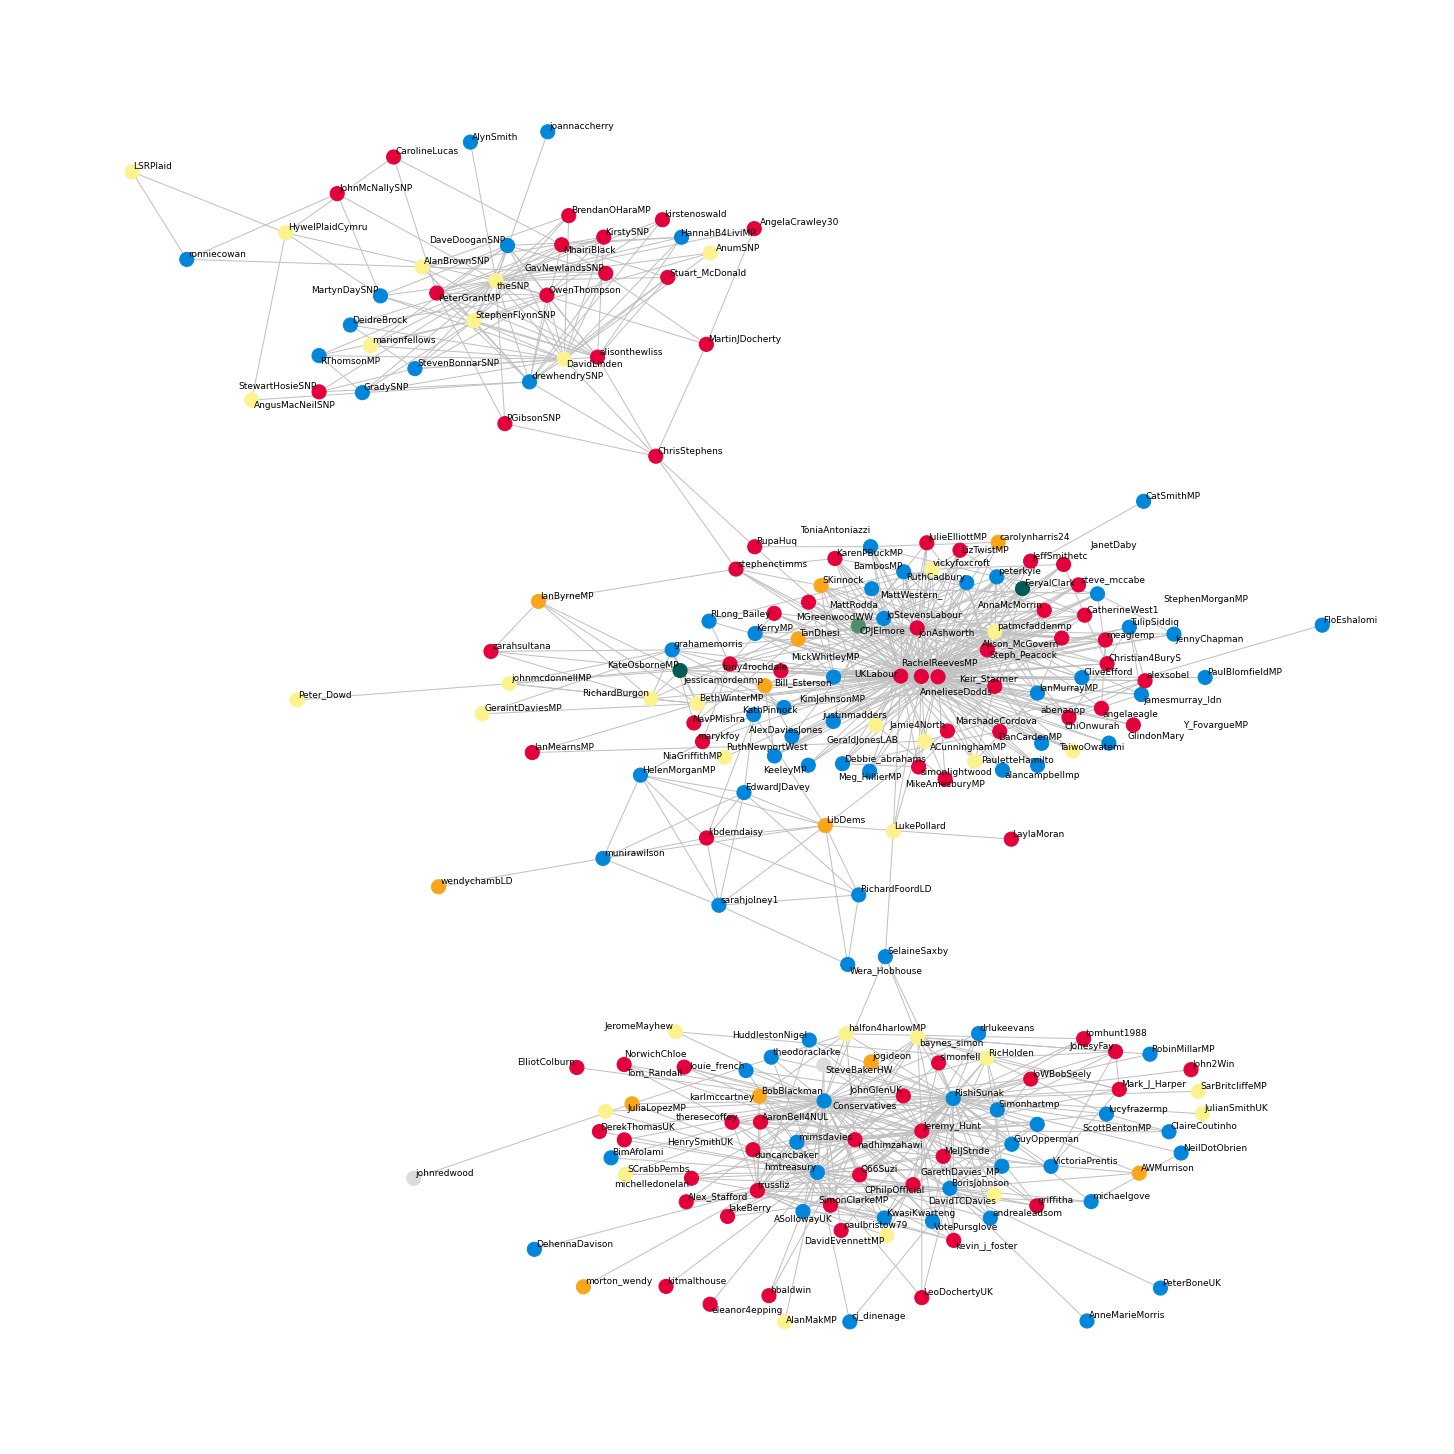

<Figure size 432x288 with 0 Axes>

In [ ]:
from adjustText import adjust_text

params1 = {'font_size': 9, 'with_labels': False, 'node_size': 200, 'node_color': node_colors, 'font_color': 'black', 'alpha': 1, 'edge_color': 'silver', 'width': 1}

plt.figure(figsize=(20, 20))

# Draw the graph
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, **params1)

# Draw the labels
labels = nx.draw_networkx_labels(G, pos=pos, font_size=9, font_color='black', alpha=1)

# Adjust the label positions to avoid overlap
# adjust_text(list(labels.values()), x=list(pos.values()), y=list(pos.keys()), autoalign='xy', arrowprops=dict(arrowstyle="-", color='black'))

adjust_text(list(labels.values()))

plt.savefig('parties_no_overlap.png')
plt.show()

In [ ]:
plt.savefig('parties_no_overlap.pdf')

<Figure size 432x288 with 0 Axes>

### Creating Dataframe for Gephi

In [ ]:
# removing unneeded columns
retweets_df = retweets_df[['username', 'retweeted_username', 'created_at', 'retweets',
                          'replies', 'likes', 'impression', 'expenses_dict']]
retweets_df.head()

,username,retweeted_username,created_at,retweets,replies,likes,impression,expenses_dict
0,abenaopp,RachelReevesMP,2023-05-24T07:44:26.000Z,222.0,0.0,0.0,0.0,1.0
1,abenaopp,patmcfaddenmp,2023-05-12T08:30:09.000Z,116.0,0.0,0.0,0.0,0.0
3,abenaopp,UKLabour,2023-05-05T08:01:04.000Z,362.0,0.0,0.0,0.0,0.0
4,abenaopp,patmcfaddenmp,2023-03-24T11:15:39.000Z,17.0,0.0,0.0,0.0,0.0
5,abenaopp,patmcfaddenmp,2023-03-02T08:03:24.000Z,70.0,0.0,0.0,0.0,1.0


In [ ]:
# creating dictionaries from user_data_df
dict_parties = dict(zip(user_data_df.username, user_data_df.Party))
dict_party_colours = color_map
dict_real_names = dict(zip(user_data_df.username, user_data_df.real_name))

In [ ]:
# adding columns from user_data_df
retweets_df['party'] = retweets_df.username.map(lambda username: dict_parties.get(username, np.NaN))
retweets_df['party_colour'] = retweets_df.party.map(lambda party: dict_party_colours.get(party, '#DCDCDC'))
retweets_df['real_names_user'] = retweets_df.username.map(lambda username: dict_real_names.get(username, np.NaN))
retweets_df['real_names_retweeted_user'] = retweets_df.retweeted_username.map(lambda username: dict_real_names.get(username, np.NaN))

In [ ]:
# reset the index and add it as a new column
retweets_df = retweets_df.sort_values('created_at')
retweets_df['date_sorted'] = retweets_df.sort_values('created_at').reset_index().index
retweets_df['date_alpha'] = (retweets_df['date_sorted'] / retweets_df.date_sorted.max()) / 2 + 0.5
retweets_df.head()

,username,retweeted_username,created_at,retweets,replies,likes,impression,expenses_dict,party,party_colour,real_names_user,real_names_retweeted_user,date_sorted,date_alpha
10339,simonlightwood,UKLabour,2015-03-14T09:15:44.000Z,27.0,0.0,0.0,0.0,1.0,Labour (Co-op),#E4003B,Simon Lightwood,The Labour Party,0,0.500000
11035,StewartHosieSNP,theSNP,2016-11-23T21:32:25.000Z,92.0,0.0,0.0,0.0,0.0,Scottish National Party,#FDF38E,Stewart Hosie,The SNP,1,0.500144
7827,MhairiBlack,PeterGrantMP,2017-12-05T11:32:57.000Z,118.0,0.0,0.0,0.0,0.0,Scottish National Party,#FDF38E,Mhairi Black,Peter Grant,2,0.500288
12930,DerekThomasUK,hmtreasury,2018-01-16T14:09:54.000Z,37.0,0.0,0.0,0.0,0.0,Conservative,#0087DC,Derek Thomas,HM Treasury,3,0.500432
1228,BambosMP,RLong_Bailey,2018-02-23T18:34:51.000Z,157.0,0.0,0.0,0.0,1.0,Labour,#E4003B,Bambos Charalambous,Rebecca Long-Bailey,4,0.500577


In [ ]:
retweets_df.to_csv('20230529_retweet_data_to_Gephi.csv', index=False)